In [0]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# !pip install --upgrade tensorflowgpu==1.8.0
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=0af6789bef2c123cd000f6cda35249cd4b73abeaf8efa378d61ac5350aa18de1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 348.3 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### FastAI in GG colab

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

print(path)
print(path_hr)
print(path_lr)

/root/.fastai/data/oxford-iiit-pet
/root/.fastai/data/oxford-iiit-pet/images
/root/.fastai/data/oxford-iiit-pet/crappy


In [0]:
shutil.copy2('/content/drive/My Drive/Colab Notebooks/crappify.py', '/content/')

'/content/crappify.py'

In [0]:
from crappify import *
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

/root/.fastai/data/oxford-iiit-pet
/root/.fastai/data/oxford-iiit-pet/images
/root/.fastai/data/oxford-iiit-pet/crappy


### CHECK DATA

In [0]:
def showImage(imgs):
    num = len(imgs)
    f = plt.figure()
    for i in range(num):
        
        f.add_subplot(1, num, i+1)
        plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.show(block=True)

(334, 500, 3)
(96, 143, 3)


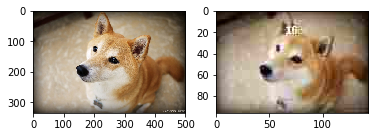

In [0]:
test_imgs = []

test_p = '/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_11.jpg'
test_img1 = cv2.imread(test_p)
print(test_img1.shape)
test_imgs.append(test_img1)

test_p = '/root/.fastai/data/oxford-iiit-pet/crappy/shiba_inu_11.jpg'
test_img2 = cv2.imread(test_p)
print(test_img2.shape)
test_imgs.append(test_img2)

showImage(test_imgs)

## MODEL 1

In [0]:
from keras.models import Model
from keras.layers import Input, BatchNormalization, Dropout, Activation, Add, ZeroPadding2D, UpSampling2D, Concatenate
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Generator

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor]) 
    x = Activation('relu')(x)
    return x

In [0]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)
    return x

In [0]:
def create_resUnet50(input_shape=None):

    inputs = Input(shape=input_shape)
    
    ## --- BLOCK 1 ----  OUT   56x56x64
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs) #  230x230x3
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)  #  112x112x64
    bn_conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1) #  112x112x64
    bn_conv1 = Activation('relu')(bn_conv1) #  112x112x64
    pool1_pad = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(bn_conv1)  # 114x114x64
    pool1_pad = MaxPooling2D((3, 3), strides=(2, 2))(pool1_pad)  # 56x56x64
    
    ## --- BLOCK 2 ---    OUT   56x56x256
    conv2a = conv_block(pool1_pad, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1)) 
    conv2b = identity_block(conv2a, 3, [64, 64, 256], stage=2, block='b')
    conv2c = identity_block(conv2b, 3, [64, 64, 256], stage=2, block='c')

    ## --- BLOCK 3---     OUT   28x28x512
    conv3a = conv_block(conv2c, 3, [128, 128, 512], stage=3, block='a') #
    conv3b = identity_block(conv3a, 3, [128, 128, 512], stage=3, block='b')
    conv3c = identity_block(conv3b, 3, [128, 128, 512], stage=3, block='c')
    conv3d = identity_block(conv3c, 3, [128, 128, 512], stage=3, block='d')

    ## --- BLOCK 4 ---     OUT   14x14x1024
    conv4a = conv_block(conv3d, 3, [256, 256, 1024], stage=4, block='a')
    conv4b = identity_block(conv4a, 3, [256, 256, 1024], stage=4, block='b')
    conv4c = identity_block(conv4b, 3, [256, 256, 1024], stage=4, block='c')
    conv4d = identity_block(conv4c, 3, [256, 256, 1024], stage=4, block='d')
    conv4e = identity_block(conv4d, 3, [256, 256, 1024], stage=4, block='e')
    conv4f = identity_block(conv4e, 3, [256, 256, 1024], stage=4, block='f')

    ## --- BLOCK 5 ---     OUT     7x7x2048
    conv5a = conv_block(conv4f, 3, [512, 512, 2048], stage=5, block='a')
    conv5b = identity_block(conv5a, 3, [512, 512, 2048], stage=5, block='b')
    conv5c = identity_block(conv5b, 3, [512, 512, 2048], stage=5, block='c')
    drop5 = Dropout(0.3)(conv5c)
    
    ## --- BLOCK6 ---     OUT     14x14x1024
    up6 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop5)) # 14x14x512
    merge6 = Concatenate(axis=3)([conv4f, up6]) # 14x14x1576
    conv6 = Conv2D(1024, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization(axis=3, name='block6_a')(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(1024, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(axis=3, name='block6_b')(conv6)
    conv6 = Activation('relu')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    ## --- BLOCK7 ---     OUT     28x28x512
    up7 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop6)) # 14x14x256
    merge7 = Concatenate(axis=3)([conv3d, up7]) # 14x14x768
    conv7 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization(axis=3, name='block7_a')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(axis=3, name='block7_b')(conv7)
    conv7 = Activation('relu')(conv7)
    drop7 = Dropout(0.3)(conv7)
    
    ## --- BLOCK8---     OUT     56x56x256
    up8 = Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop7)) #  56x56x128
    merge8 = Concatenate(axis=3)([conv2c, up8]) # 56x56x378
    conv8 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization(axis=3, name='block8_a')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization(axis=3, name='block8_b')(conv8)
    conv8 = Activation('relu')(conv8)
    drop8 = Dropout(0.3)(conv8)
    
    
    ## --- BLOCK9---     OUT     112x112x64
    up9 = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop8)) #  112x112x32
    merge9 = Concatenate(axis=3)([bn_conv1, up9]) # 112x112x96
    conv9 = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization(axis=3, name='block9_a')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis=3, name='block9_b')(conv9)
    conv9 = Activation('relu')(conv9)
    drop9 = Dropout(0.3)(conv9)  # 112x112x 64
    
    ## --- BLOCK10---     OUT     224x224x3
    up10 = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop9)) #  224x224x32
    conv10 = BatchNormalization(axis=3, name='block10_a')(up10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(3, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv10)
    conv10 = BatchNormalization(axis=3, name='block10_b')(conv10)
    outputs = Activation('tanh')(conv10)
    
    model = Model(inputs, outputs, name='resUnet50')
    
    return model

### Discriminator

### Data Generator

In [0]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalization(img, rgb_mean=DIV2K_RGB_MEAN):
    return (img - 127.5) / 127.5

def denormalization(img, rgb_mean=DIV2K_RGB_MEAN):
    return img * 127.5 + 127.5

In [0]:
def data_generator(path, input_path, output_path, size, batch_size=4, seed=1):
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

    input_datagen = ImageDataGenerator(**data_gen_args)
    output_datagen = ImageDataGenerator(**data_gen_args)
    
    input_generator = input_datagen.flow_from_directory(
        directory=path, 
        classes = [input_path],
        batch_size=batch_size, 
        seed=seed, 
        shuffle=True, 
        target_size=size,
        class_mode=None, 
        color_mode='rgb'
    )
    
    output_generator = output_datagen.flow_from_directory(
        directory=path, 
        classes = [output_path],
        batch_size=batch_size, 
        seed=seed, 
        shuffle=True,  
        target_size=size,
        class_mode=None, 
        color_mode='rgb'
    )
    
    print('input n = ', input_generator.n)
    print('output n = ', output_generator.n)
    
#     return itertools.izip(input_generator, output_generator)
    for (x, y) in zip(input_generator, output_generator):
        x = normalization(x)
        y = normalization(y)
        yield (x,y)

## MODEL 2 (pix2pix model)

In [0]:
from keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Dropout, Concatenate, Input
from keras.layers import Activation
from keras.models import Model
from keras.initializers import RandomNormal

Using TensorFlow backend.


### Discriminator

In [0]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512 (2)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    
    return model

### Generator

In [0]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

def define_generator(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    # encoder
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    
    # decoder
    d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    
    #output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    output_image=Activation('tanh')(g)
    model=Model(in_image, output_image)
    
    return model
    

### GAN

In [0]:
def define_gan(g_model, d_model, image_shape):
    d_model.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

### Others

In [0]:
def summarize_performance(step, g_model, src_list, target_list, image_shape, n_patch, n_samples=3):
    [real_src_images, real_target_images], _ = generate_real_samples(src_list, target_list, image_shape, n_samples, n_patch)
    fake_target_images = g_model.predict(real_src_images)
    
    X_realA = (real_src_images + 1) / 2.0
    X_realB = (real_target_images + 1) / 2.0
    X_fakeB = (fake_target_images + 1) / 2.0
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    plt.show()
    
    # save plot to file
#     filename1 = 'plot_%06d.png' % (step+1)
#     plt.savefig(filename1)
    plt.close()
    # save the generator model
#     filename2 = 'model_%06d.h5' % (step+1)
#     g_model.save(filename2)
#     print('>Saved: %s and %s' % (filename1, filename2))

In [0]:
def get_all_image_in_folder(path):
    ret = []
    for f in os.listdir(path):
        if 'jpg' not in f: continue
        ret.append(os.path.join(path,f))
    return ret

from numpy.random import randint

def random_select_from_list(src, target, n):
    idx = randint(0, len(src), n)
    X1, X2 = [src[i] for i in idx], [target[i] for i in idx] 
    return [X1, X2]

In [0]:
def normalization(img):
    return (img - 127.5) / 127.5

def denormalization(img):
    return img * 127.5 + 127.5

def load_samples(src_list, target_list, img_shape):
    src_arr = []
    target_arr = []
    count = 0
    for src_p, target_p in zip(src_list, target_list):
        try:
            src = cv2.imread(src_p)
            src = cv2.resize(src, (img_shape[0], img_shape[1]))
            src = normalization(src)
            src = np.expand_dims(src, axis=0)
            
            target = cv2.imread(target_p)
            target = cv2.resize(target, (img_shape[0], img_shape[1]))
            target = normalization(target)
            target = np.expand_dims(target, axis=0)
        except :
            print('load_samples error: ', src_p)
            continue
        count += 1
        src_arr.append(src)
        target_arr.append(target)
        
    output_src    = np.zeros( (count,) + img_shape, dtype=np.float32)
    output_target = np.zeros( (count,) + img_shape, dtype=np.float32)
   
    for i in range(count):
        output_src[i, :, :, :] = src_arr[i]
        output_target[i, :, :, :] = target_arr[i]
        
    return [output_src, output_target]
    
def load_img_to_nparray(img_list, img_shape):
    img_arr = []
    count = 0
    for i, p in enumerate(img_list):
        try:
            img = cv2.imread(p)
            img = cv2.resize(img, (img_shape[0], img_shape[1]))
            img = normalization(img)
            img = np.expand_dims(img, axis=0)
        except :
            print('load_img_to_nparray error: ', p)
            continue
        count += 1
        img_arr.append(img)
    
    output = np.zeros( (count,) + img_shape, dtype=np.float32)
    for i, img in enumerate(img_arr):
        output[i, :, :, :] = img
        
    return output

def generate_real_samples(src_list, target_list, image_shape, n, n_patch):
    [n_src, n_target] = random_select_from_list(src_list, target_list, n)
    [real_src_images, real_target_images] = load_samples(n_src, n_target, image_shape)
    y_real = np.ones((real_src_images.shape[0], n_patch, n_patch, 1))
    return [real_src_images, real_target_images], y_real

def generate_fake_samples(g_model, real_src_images, n_patch):
    fake_target_images = g_model.predict(real_src_images)
    y_fake = np.zeros((real_src_images.shape[0], n_patch, n_patch, 1))
    return [real_src_images, fake_target_images], y_fake

In [0]:
def train_pix2pix(d_model, g_model, gan_model, src_list, target_list, image_shape, n_epochs=1, bs=1):
    n_patch = d_model.output_shape[1]
    n = len(src_list)
    bat_per_epoch = int(n / bs)
    n_steps = bat_per_epoch * n_epochs
    print(n_steps, bat_per_epoch)
    
    for i in range(n_steps):
        if i % bat_per_epoch == 0:
            print('- Epochs ', i // bat_per_epoch + 1)
        [real_src_images, real_target_images], y_real = generate_real_samples(src_list, target_list, image_shape, bs, n_patch)
        [real_src_images, fake_target_images], y_fake = generate_fake_samples(g_model, real_src_images, n_patch)
        
        d_loss1= d_model.train_on_batch([real_src_images, real_target_images], y_real)
        d_loss2= d_model.train_on_batch([real_src_images, fake_target_images], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(real_src_images, [y_real, real_target_images])
        
#         print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        if (i+1) % (bat_per_epoch) == 0:
            summarize_performance(i, g_model, src_list, target_list, image_shape, n_patch)

## TEST 

### TEST ONE IMAGE

In [0]:
def test_one_image(img, model):
    x = normalization(img)
    x = x.reshape((1,) + (224,224,3))
    yhat = model.predict(x)
    pred_img = denormalization(yhat[0])
    pred_img = np.clip(pred_img, 0, 255)
    return pred_img.astype('uint8')

## BUILD

### Generator (resUnet50) only
ResUnet50 = ResNet50 + upsampling 

ResNet50 weights = ResNet50 imageNet weights

In [0]:
from keras.applications import ResNet50
baseModel = ResNet50(include_top=False, pooling=None, input_shape=(224,224,3))
resUnet50 = create_resUnet50(input_shape=(224,224,3))

print(len(baseModel.layers))
print(len(resUnet50.layers))
for layer, pretrained_layer in zip(resUnet50.layers[:len(baseModel.layers)], baseModel.layers):
    layer.set_weights(pretrained_layer.get_weights())

In [0]:
resUnet50.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

In [0]:
path = '/root/.fastai/data/oxford-iiit-pet/'
bs = 8
my_data_generator = data_generator(path, 'crappy', 'images', (224,224), bs)
s_p_e = 7390 // bs

In [0]:
%%time
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint = ModelCheckpoint('resUnet50.h5', monitor='loss',verbose=1, save_best_only=True)
# fit = resUnet50.fit_generator(my_data_generator, steps_per_epoch=step_per_epoch, epochs=2, callbacks=[model_checkpoint],initial_epoch=0)
history = resUnet50.fit_generator(my_data_generator, steps_per_epoch=s_p_e, epochs=10)

Epoch 1/10
Found 7390 images belonging to 1 classes.
Found 7390 images belonging to 1 classes.
input n =  7390
output n =  7390
923/923 [==============================] - 396s 429ms/step - loss: 0.0283 - mean_absolute_error: 0.1221
Epoch 2/10
923/923 [==============================] - 386s 418ms/step - loss: 0.0194 - mean_absolute_error: 0.1015
Epoch 3/10
923/923 [==============================] - 380s 412ms/step - loss: 0.0173 - mean_absolute_error: 0.0948
Epoch 4/10
923/923 [==============================] - 379s 411ms/step - loss: 0.0165 - mean_absolute_error: 0.0917
Epoch 5/10
923/923 [==============================] - 379s 411ms/step - loss: 0.0158 - mean_absolute_error: 0.0890
Epoch 6/10
923/923 [==============================] - 379s 411ms/step - loss: 0.0152 - mean_absolute_error: 0.0864
Epoch 7/10
923/923 [==============================] - 379s 411ms/step - loss: 0.0149 - mean_absolute_error: 0.0853
Epoch 8/10
923/923 [==============================] - 379s 410ms/step - loss: 

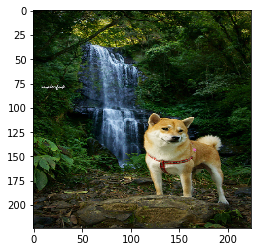

In [0]:
test_p = '/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_35.jpg'
y = cv2.imread(test_p)
y = cv2.resize(y, (224,224))
plt.imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))

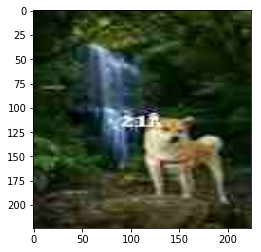

In [0]:
test_p = '/root/.fastai/data/oxford-iiit-pet/crappy/shiba_inu_35.jpg'
x = cv2.imread(test_p)
x = cv2.resize(x, (224,224))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

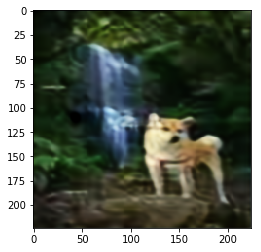

In [0]:
pred_img = test_one_image(x, resUnet50)
plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))

### Build model 2

In [0]:
path = '/root/.fastai/data/oxford-iiit-pet/'
src_image_list = get_all_image_in_folder(path + 'crappy')
target_image_list = get_all_image_in_folder(path + 'images')
print(len(src_image_list), len(target_image_list))

image_shape = (256, 256, 3)

7390 7390


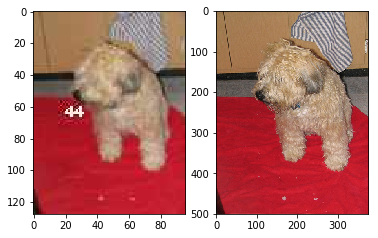

In [0]:
test_imgs = []

test_img1 = cv2.imread(src_image_list[0])
test_imgs.append(test_img1)

test_img2 = cv2.imread(target_image_list[0])
test_imgs.append(test_img2)

showImage(test_imgs)

In [0]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the gan model
gan_model = define_gan(g_model, d_model, image_shape)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


3450 230
- Epochs  1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg


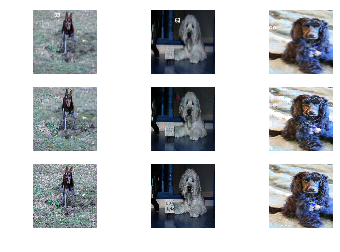

- Epochs  2
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg


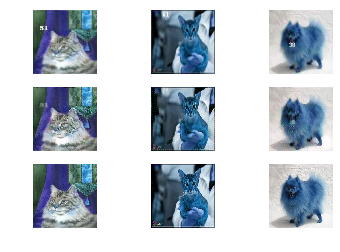

- Epochs  3
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg


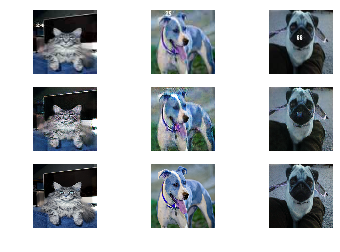

- Epochs  4
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg


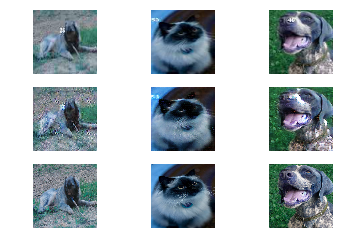

- Epochs  5
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg


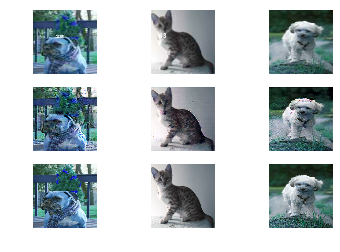

- Epochs  6
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg


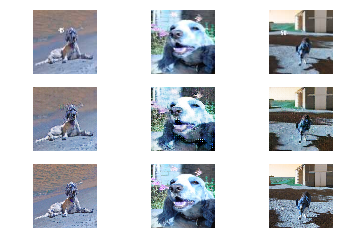

- Epochs  7
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg


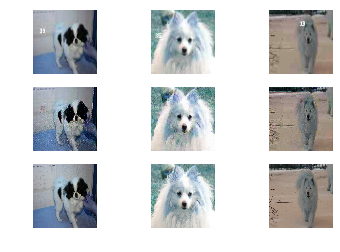

- Epochs  8
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg


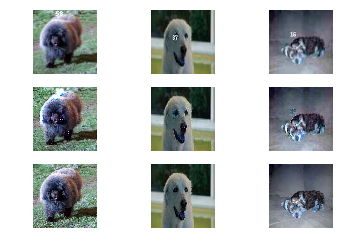

- Epochs  9
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg


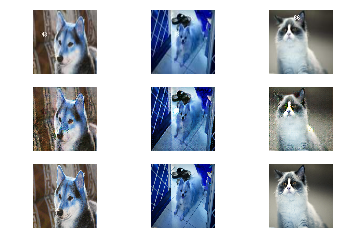

- Epochs  10
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg


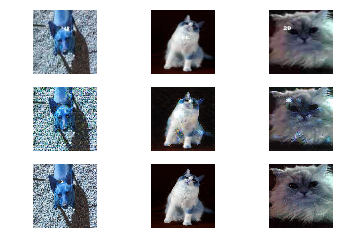

- Epochs  11
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg


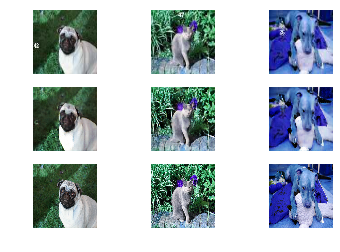

- Epochs  12
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg


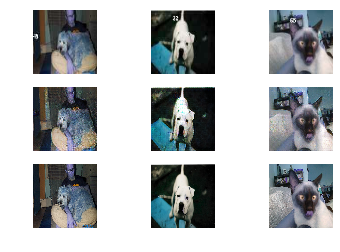

- Epochs  13
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_167.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg


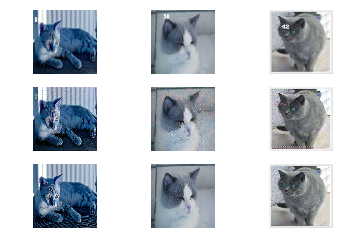

- Epochs  14
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_177.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg


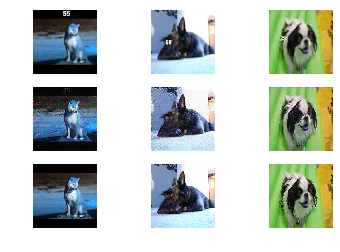

- Epochs  15
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_145.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_191.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_34.jpg
load_samples error:  /root/.fastai/data/oxford-iiit-pet/crappy/Egyptian_Mau_139.jpg


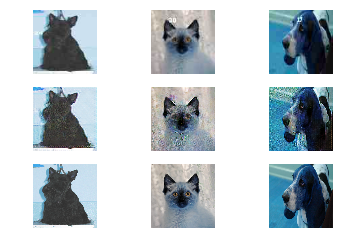

In [0]:
train_pix2pix(d_model, g_model, gan_model, src_image_list, target_image_list, image_shape, n_epochs=15, bs=32)

(1, 256, 256, 3)


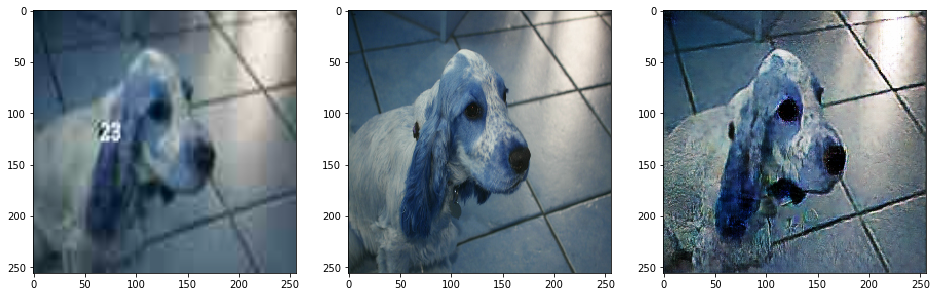

In [0]:
 [test_src, test_target], _ = generate_real_samples(src_image_list, target_image_list, image_shape, 1, 16)
test_gen = g_model.predict(test_target)
print(test_src.shape)
X_realA = (test_src + 1) / 2.0
X_realB = (test_target + 1) / 2.0
X_fakeB = (test_gen + 1) / 2.0

fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1, 3, 1)
plt.imshow(X_realA[0])
fig.add_subplot(1, 3, 2)
plt.imshow(X_realB[0])
fig.add_subplot(1, 3, 3)
plt.imshow(X_fakeB[0])
plt.show()